In [1]:
%matplotlib inline
# coding:utf8

import torch
import torchvision
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 
import numpy as np

img_tensor = torch.zeros((1, 3, 800, 800)).float()
print(img_tensor.shape)
# Out: torch.Size([1, 3, 800, 800])

img_var = torch.autograd.Variable(img_tensor)

model = torchvision.models.vgg16(pretrained=False)
fe = list(model.features)
# print(fe)  # length is 15

req_features = []
k = img_var.clone()
for i in fe:
    print(i)
    k = i(k)
    print(k.data.shape)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))  # 30
print(out_channels)  # 512

torch.Size([1, 3, 800, 800])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 800, 800])
ReLU(inplace=True)
torch.Size([1, 64, 800, 800])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 800, 800])
ReLU(inplace=True)
torch.Size([1, 64, 800, 800])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 64, 400, 400])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 400, 400])
ReLU(inplace=True)
torch.Size([1, 128, 400, 400])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 400, 400])
ReLU(inplace=True)
torch.Size([1, 128, 400, 400])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 128, 200, 200])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 256, 200, 200])
ReLU(inplace=True)
torch.Size([1, 256, 200, 200])
Conv2d(256, 256, kernel_s

In [2]:
for f in req_features:
    print(f)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [3]:
faster_rcnn_fe_extractor = torch.nn.Sequential(*req_features)
out_map = faster_rcnn_fe_extractor(img_var)
print(out_map.size())
# Out: torch.Size([1, 512, 50, 50])

torch.Size([1, 512, 50, 50])


In [4]:
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]
sub_sample = 16

# 一个特征点对应原图片中的16*16个像素点区域
fe_size = (800//16)
# ctr_x， ctr_y: 每个特征点对应原图片区域的右下方坐标
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x))  # 共50*50个特征点，将原图片分割成50*50=2500个区域

50


In [5]:
index = 0
# ctr: 每个特征点对应原图片区域的中心点
ctr = dict()
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index] = [-1, -1]
        ctr[index][1] = ctr_x[x] - 8
        ctr[index][0] = ctr_y[y] - 8
        index += 1
# print ctr
print(len(ctr))  # 将原图片分割成50*50=2500个区域的中心点

2500


In [6]:
# 初始化：每个区域有9个anchors候选框，每个候选框的坐标(y1, x1, y2, x2)
anchors = np.zeros(((fe_size * fe_size * 9), 4))
# (22500, 4)
print(anchors.shape)
index = 0
# 将候选框的坐标赋值到anchors
for c in ctr:
    ctr_y, ctr_x = ctr[c]
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            # anchor_scales 是针对特征图的，所以需要乘以下采样"sub_sample"
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1. / ratios[i])
            anchors[index, 0] = ctr_y - h / 2.
            anchors[index, 1] = ctr_x - w / 2.
            anchors[index, 2] = ctr_y + h / 2.
            anchors[index, 3] = ctr_x + w / 2.
            index += 1
# (22500, 4)
print(anchors.shape)

(22500, 4)
(22500, 4)


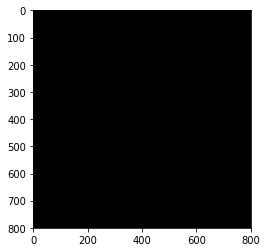

In [8]:
img_npy = img_tensor.numpy()
img_npy = np.transpose(img_npy[0], (1, 2, 0)).astype(np.float32)
img = Image.fromarray(np.uint8(img_npy))
draw = ImageDraw.Draw(img)
plt.imshow(img)

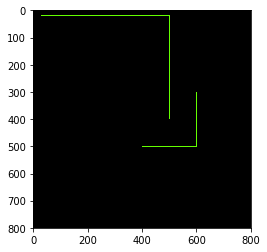

In [9]:
# for index in range(15000, 15009):
# for index in range(len(anchors)):
#     draw.rectangle([(anchors[index, 1], anchors[index, 0]), (anchors[index, 3], anchors[index, 2])],
#                    outline=(255, 0, 0))

# 假设 图片中的两个目标框"ground-truth"
bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32)  # [y1, x1, y2, x2] format
draw.rectangle([(30, 20), (500, 400)], outline=(100, 255, 0))
draw.rectangle([(400, 300), (600, 500)], outline=(100, 255, 0))
plt.imshow(img)

In [10]:
# 假设 图片中两个目标框分别对应的标签
labels = np.asarray([6, 8], dtype=np.int8)  # 0 represents background

# 去除坐标出界的边框，保留图片内的框——图片内框
valid_anchor_index = np.where(
       (anchors[:, 0] >= 0) &
       (anchors[:, 1] >= 0) &
       (anchors[:, 2] <= 800) &
       (anchors[:, 3] <= 800)
   )[0]  # 该函数返回数组中满足条件的index
print(valid_anchor_index.shape)  # (8940,)，表明有8940个框满足条件

(8940,)


In [11]:
# 获取有效anchor（即边框都在图片内的anchor）的坐标
valid_anchor_boxes = anchors[valid_anchor_index]
print(valid_anchor_boxes.shape)  # (8940, 4)

(8940, 4)


In [13]:
# 计算有效anchor框"valid_anchor_boxes"与目标框"bbox"的IOU
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
print(bbox)

[[ 20.  30. 400. 500.]
 [300. 400. 500. 600.]]


In [15]:
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)  # anchor框面积
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)  # 目标框面积
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)  # anchor框和目标框的相交面积
            iou = iter_area / (anchor_area + box_area - iter_area)  # IOU计算
        else:
            iou = 0.0
        ious[num1, num2] = iou
print(ious.shape)  # (8940, 2)  表示每个anchor框与所有目标框的IOU，这里所有的目标框共2个。
ious[0:5, :]

(8940, 2)


array([[0.06811669, 0.        ],
       [0.07083762, 0.        ],
       [0.07083762, 0.        ],
       [0.07083762, 0.        ],
       [0.07083762, 0.        ]], dtype=float32)

In [16]:
gt_argmax_ious = ious.argmax(axis=0)  # 找出每个目标框最大IOU的anchor框index，共2个
print(gt_argmax_ious)  # 共2个，与图片内目标框数量一致

[2262 5620]


In [17]:
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]  # 获取每个目标框最大IOU的值，与gt_argmax_ious对应
print(gt_max_ious)  # 共2个，与图片内目标框数量一致

[0.68130493 0.61035156]


In [18]:
argmax_ious = ious.argmax(axis=1)  # 找出每个anchor框最大IOU的目标框index，共8940个
print(argmax_ious.shape)  # (8940,) 每个anchor框都会对应一个最大IOU的目标框
max_ious = ious[np.arange(len(valid_anchor_index)), argmax_ious]  # 获取每个anchor框的最大IOU值， 与argmax_ious对应
print(max_ious.shape)  # (8940,),每个anchor框内都会有一个最大值

(8940,)
(8940,)


(18,)
[  8.   8. 520. 520.]
[  8.  24. 520. 536.]
[248. 344. 504. 600.]
[264. 344. 520. 600.]
[280. 344. 536. 600.]
[296. 344. 552. 600.]
[248. 360. 504. 616.]
[264. 360. 520. 616.]
[280. 360. 536. 616.]
[296. 360. 552. 616.]
[248. 376. 504. 632.]
[264. 376. 520. 632.]
[280. 376. 536. 632.]
[296. 376. 552. 632.]
[248. 392. 504. 648.]
[264. 392. 520. 648.]
[280. 392. 536. 648.]
[296. 392. 552. 648.]


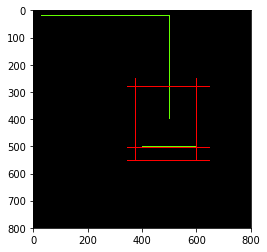

In [20]:
# 疑问： ious == gt_max_ious， 有区分目标
gt_argmax_ious = np.where(ious == gt_max_ious)[0]  # 根据上面获取的目标最大IOU值，获取等于该值的index
print(gt_argmax_ious.shape)  # (18,) 共计18个
for index in gt_argmax_ious:
    print(valid_anchor_boxes[index, :])
    draw.rectangle([(valid_anchor_boxes[index, 1], valid_anchor_boxes[index, 0]),
                    (valid_anchor_boxes[index, 3], valid_anchor_boxes[index, 2])], outline=(255, 0, 0))
plt.imshow(img)

In [21]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label = np.empty((len(valid_anchor_index), ), dtype=np.int32)
label.fill(-1)
print(label.shape)  # (8940,)
label[max_ious < neg_iou_threshold] = 0  # anchor框内最大IOU值小于neg_iou_threshold，设为0
label[gt_argmax_ious] = 1  # anchor框有全局最大IOU值，设为1
label[max_ious >= pos_iou_threshold] = 1  # anchor框内最大IOU值大于等于pos_iou_threshold，设为1

pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample  # 正例样本数

# 随机获取n_pos个正例，
pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = n_sample - np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1
print(np.sum(label == 1))  # 18个正例
print(np.sum(label == 0))  # 256-18=238个负例

(8940,)
18
238


In [22]:
# 现在让我们用具有最大iou的ground truth对象为每个anchor box分配位置。
# 注意，我们将为所有有效的anchor box分配anchor locs，而不考虑其标签，稍后在计算损失时，我们可以使用简单的过滤器删除它们。
max_iou_bbox = bbox[argmax_ious]  # 有效anchor框对应的目标框坐标  (8940, 4)
print(max_iou_bbox)
print(max_iou_bbox.shape)  # (8940, 4)，共有8940个有效anchor框，每个anchor有坐标值（y1, x1, y2, x2）

[[ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 ...
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]]
(8940, 4)


In [23]:
# 有效anchor的中心点和宽高：ctr_x, ctr_y, width, height
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width
# 有效anchor对应目标框的中心点和宽高: base_ctr_x, base_ctr_y, base_width, base_height
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# 有效anchor转为目标框的系数（dy，dx是平移系数；dh，dw是缩放系数）
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
# print anchor_locs
print(anchor_locs.shape)

(8940, 4)
